In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from impyute.imputation.cs import mice
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, confusion_matrix
from xgboost import XGBClassifier
from xgboost import plot_importance

# Data Processing and EDA

In [2]:
#read in data
all_fund = pd.read_csv('all_companies_fund.csv') #2000-2019
all_bank = pd.read_csv('all_bankruptcies.csv', encoding = "ISO-8859-1") #2000-2019

C:\Users\Hannah\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (2,33,37,955,956,957,962,972,976,977,982) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\Hannah\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (263,341) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [88]:
all_fund.columns
list(all_bank.columns)
# all_bank['SHORT_NAME']

['BANKRUPTCY_TYPE',
 'BANK_BEGIN_DATE',
 'SIC_CODE_FKEY',
 'SIC_CODE_DESCRIP',
 'NAICS_CODE_DESCRIP',
 'NAICS_CODE_FKEY',
 'SHORT_NAME',
 'NAME',
 'COMPANY_FKEY',
 'year']

In [3]:
#keys to join all databases
key_table = all_fund[['cik', 'GVKEY']] 
key_table = key_table.drop_duplicates()
key_table.head()

,cik,GVKEY
0,1750.0,1004
19,910627.0,1010
23,61478.0,1013
34,2668.0,1019
36,319126.0,1021


In [4]:
mask = all_fund['stalt'] == 'TL'
tl = all_fund[mask]
tl

,GVKEY,LINKPRIM,LIID,LINKTYPE,LPERMNO,LPERMCO,LINKDT,LINKENDDT,datadate,fyear,...,priusa,sic,spcindcd,spcseccd,spcsrc,state,stko,weburl,dldte,ipodate
73,1045,P,01,NR,NaN,NaN,01/05/2012,11/30/2013,12/31/2012,2012.0,...,4.0,4512,605.0,600.0,B-,TX,0.0,www.aa.com,NaN,NaN
473,1164,P,01,NR,NaN,NaN,07/30/2002,03/31/2004,12/31/2002,2002.0,...,10.0,4813,463.0,974.0,NaN,NJ,0.0,www.wcom.com/home.shtml,01/09/2006,NaN
867,1263,N,01C,NU,NaN,NaN,12/01/2000,12/31/2001,12/31/2001,2001.0,...,6.0,3312,460.0,970.0,NaN,ON,2.0,www.algoma.com,NaN,NaN
868,1263,P,01,NR,NaN,NaN,12/01/2000,01/31/2002,12/31/2001,2001.0,...,6.0,3312,460.0,970.0,NaN,ON,2.0,www.algoma.com,NaN,NaN
1167,1388,C,00X,NU,NaN,NaN,01/01/1983,E,12/31/2011,2011.0,...,1.0,4512,605.0,600.0,NaN,TX,1.0,www.aa.com,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236932,273726,P,01,LC,93338.0,53385.0,04/15/2010,06/30/2018,12/31/2017,2017.0,...,2.0,1381,NaN,NaN,NaN,NaN,0.0,www.seadrill.com,NaN,04/15/2010
237802,294524,C,00X,NR,NaN,NaN,01/01/2006,04/29/2010,12/31/2009,2009.0,...,1.0,2820,NaN,NaN,B+,NaN,0.0,www.lyondellbasell.com,NaN,NaN
237889,296944,N,01,NR,NaN,NaN,01/29/2014,E,12/31/2017,2017.0,...,2.0,1381,NaN,NaN,NaN,NaN,3.0,www.nadlcorp.com,07/03/2018,NaN
237890,296944,P,02,LC,14417.0,54709.0,01/29/2014,07/03/2018,12/31/2017,2017.0,...,2.0,1381,NaN,NaN,NaN,NaN,3.0,www.nadlcorp.com,07/03/2018,NaN


In [5]:
all_fund[all_fund['GVKEY'] == 273726][['datadate','stalt','cik']]

,datadate,stalt,cik
236923,12/31/2008,NaN,1737706.0
236924,12/31/2009,NaN,1737706.0
236925,12/31/2010,NaN,1737706.0
236926,12/31/2011,NaN,1737706.0
236927,12/31/2012,NaN,1737706.0
236928,12/31/2013,NaN,1737706.0
236929,12/31/2014,NaN,1737706.0
236930,12/31/2015,NaN,1737706.0
236931,12/31/2016,NaN,1737706.0
236932,12/31/2017,TL,1737706.0


In [6]:
all_bank[all_bank['COMPANY_FKEY'] == 1737706]

,BANK_KEY,SUBSID_NAME,BANKRUPTCY_TYPE,LAW_COURT_FKEY,COURT_TYPE_CODE,COURT_NAME,COURT_S_NAME,COURT_LOC_STREET,COURT_LOC_CITY,COURT_LOC_STATE,...,HIWATER_INCMST_REVFY,HIWATER_INCMST_NETINC_QTR_DATE,HIWATER_INCMST_NETINC_QTR,HIWATER_INCMST_NETINC_TTM_DATE,HIWATER_INCMST_NETINC_TTM,HIWATER_INCMST_NETINC_FY_DATE,HIWATER_INCMST_NETINC_FY,NAME_CHANGE_DATE1,NAME_CHANGE_DATE2,NAME_CHANGE_DATE3


## Bankruptcy Data EDA

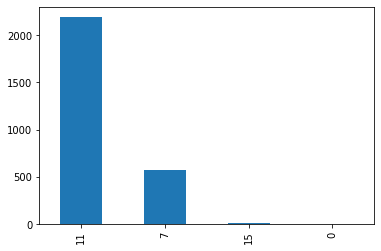

In [7]:
all_bank['BANKRUPTCY_TYPE'].value_counts().plot(kind = 'bar')

In [8]:
#extract useful information
all_bank = all_bank[['BANKRUPTCY_TYPE', 'BANK_BEGIN_DATE', 'SIC_CODE_FKEY', 'SIC_CODE_DESCRIP', 'NAICS_CODE_DESCRIP', 'NAICS_CODE_FKEY', 'SHORT_NAME', 'NAME', 'COMPANY_FKEY']]

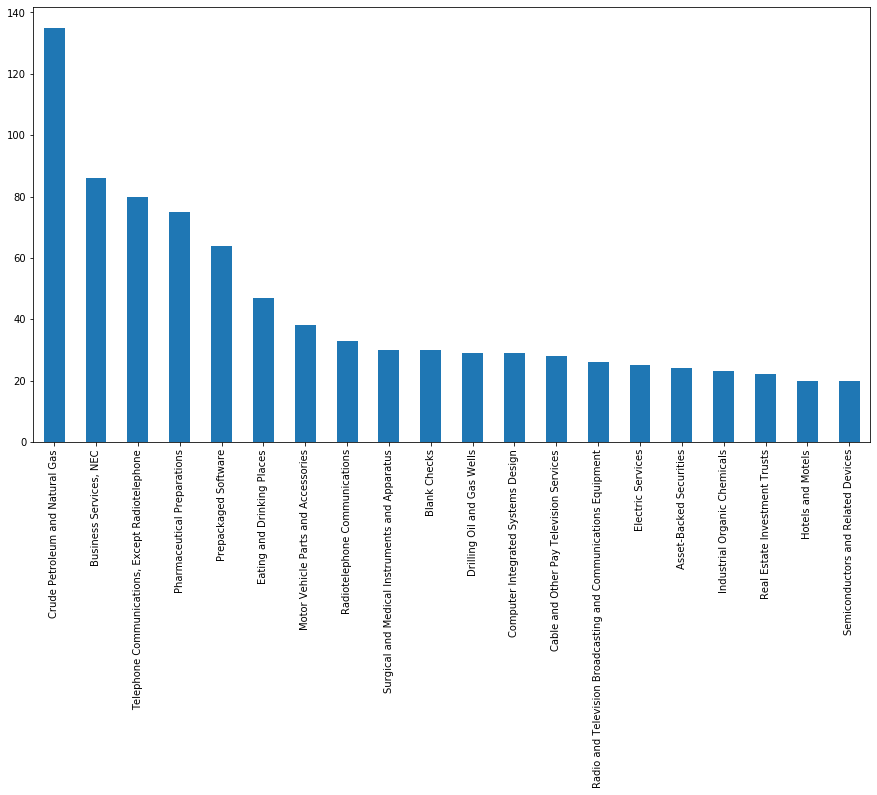

In [9]:
#top 20 industries with most bankruptcies using SIC code

all_bank['SIC_CODE_DESCRIP'].value_counts(ascending = False)[:20].plot(kind = 'bar', figsize = (15,8))

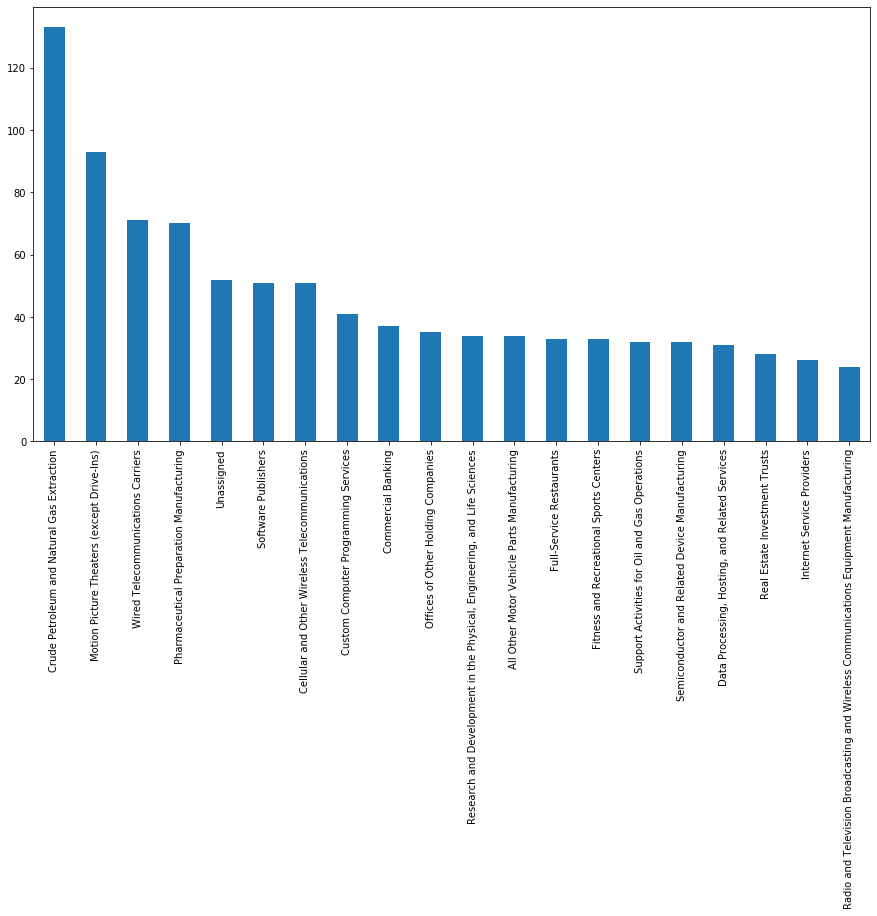

In [10]:
#top 20 industries with most bankruptcies using NICS code

all_bank['NAICS_CODE_DESCRIP'].value_counts(ascending = False)[:20].plot(kind = 'bar', figsize = (15,8))

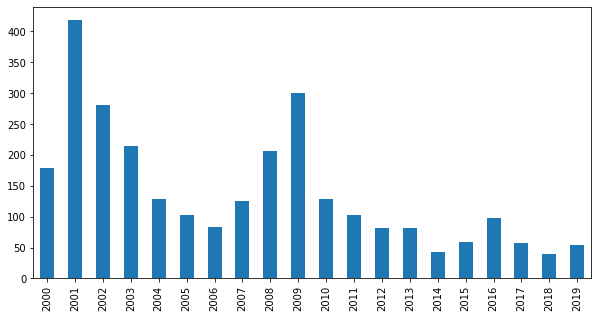

In [11]:
all_bank['year'] = pd.to_datetime(all_bank['BANK_BEGIN_DATE']).dt.year
all_bank['year'].value_counts().sort_index().plot(kind = 'bar', figsize = (10,5))

In [12]:
# gvkey_list = str(list(all_fund['GVKEY'].unique())).strip('\'').strip('[').strip(']').split(', ')

# # Write to txt file to look up relevant companies in Audit Analytics database
# # file = open('all_GVKEY.txt','w')
# # for i in all_fund['GVKEY']:
# #     file.write(str(i))
# #     file.write('\n')
# # file.close()

print(all_fund['GVKEY'].nunique(), 'of unique GVKEYs')
print(all_fund['cik'].nunique(), 'of unique ciks')
print('cik is the only way to join to bankruptcy data, might explain why so many bankruptcies were dropped')

24933 of unique GVKEYs
17998 of unique ciks
cik is the only way to join to bankruptcy data, might explain why so many bankruptcies were dropped


In [13]:
# all_bank.groupby(['year', 'NAICS_CODE_DESCRIP'])[['NAICS_CODE_DESCRIP']].count().unstack().to_csv('industrybank.csv')

In [14]:
# all_bank.groupby(['year', 'SIC_CODE_DESCRIP'])[['NAICS_CODE_DESCRIP']].count().unstack().to_csv('sicbank.csv')

In [15]:
all_bank.shape

(2779, 10)

In [16]:
f_keys = list(all_bank['COMPANY_FKEY'])

In [17]:
ciks = list(key_table['cik'])

In [18]:
#test how many bankrupt Fkeys are in fundamental
x = [] 
for i in f_keys:
    
    if i in ciks:
        continue
    
    else:
        x.append(i)
        #print (i, 'not in fundamental')

In [19]:
print('Of', len(f_keys), 'bankrupt companies,', len(x), 'companies are not in fundamental dataset')

Of 2779 bankrupt companies, 1085 companies are not in fundamental dataset


In [20]:
# # gvkey_list = str(list(all_fund['GVKEY'].unique())).strip('\'').strip('[').strip(']').split(', ')

# # Write to txt file to look up relevant companies in Audit Analytics database
# file = open('all_fkey.txt','w')
# for i in all_bank['COMPANY_FKEY']:
#     file.write(str(i))
#     file.write('\n')
# file.close()

In [21]:
#used bankruptcy Fkey to query fundamental data, turns out a lot of ciks do not return fundamental data
fund_bank = pd.read_csv('fund_bank.csv')
fund_bank['cik'].nunique()

C:\Users\Hannah\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (23,33,955,956,958,959,965,976,977,980,981,982,983,985,989,995,996,999,1002,1005,1010,1017,1018,1021,1025,1030,1033,1034,1039,1049,1050,1055,1056,1057,1058,1059,1060,1061,1065,1066,1069,1070,1072,1074,1076,1077,1081,1082,1083,1093,1095,1099,1100,1107,1111,1112,1113,1114,1116,1120,1127,1134,1137,1141,1144,1145,1146,1148,1149,1150,1159,1160,1162,1163,1164,1165,1167,1168,1829,1830,1836,1850,1851) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1798

In [22]:
print('will move forward with the companies with fundamental data')
print('might be benefitial to figure out why so many companies do not have fundamental data')

will move forward with the companies with fundamental data
might be benefitial to figure out why so many companies do not have fundamental data


## Merge fundamental and bankruptcy and financial ratios


In [23]:
fund_bank = pd.merge(all_fund, all_bank, left_on = 'cik', right_on = 'COMPANY_FKEY', suffixes = ('_fund', '_bank'), how = 'left')
fund_bank['cik'].nunique()

17998

In [24]:
bankrupt_key  = pd.merge(all_bank, key_table, left_on = 'COMPANY_FKEY', right_on = 'cik', suffixes = ('_ratio', '_key'), how = 'inner')


In [25]:
all_fin_ratios  = pd.read_csv('all_fin_ratios.csv')

In [26]:
#only keep year end financial ratios for each company
all_fin_ratios=all_fin_ratios.drop_duplicates(subset=['gvkey','qdate'], keep='last')
all_fin_ratios['qmonth']=pd.to_datetime(all_fin_ratios['qdate']).dt.month
mask= all_fin_ratios['qmonth']==12
all_fin_ratios= all_fin_ratios[mask]

all_fin_ratios.shape

(75263, 76)

In [27]:
fin_gv = list(all_fin_ratios['gvkey'].unique())

fund_gv = list(all_fund['GVKEY'].unique())

#test how many bankrupt Fkeys are in fundamental
x = [] 
for i in fin_gv:
    
    if i in fund_gv:
        continue
    
    else:
        x.append(i)
        #print (i, 'not in fundamental')

In [28]:
print('Of', len(fin_gv), 'companies with financial ratios', len(x), 'companies are not in fundamental dataset')

Of 9466 companies with financial ratios 560 companies are not in fundamental dataset


In [29]:
fin_ratio_bankruptcy = pd.merge(all_fin_ratios, bankrupt_key, left_on = 'gvkey', right_on = 'GVKEY', suffixes = ('_finratio', '_bankrupt'), how = 'left')


In [30]:
mask = pd.to_datetime(fin_ratio_bankruptcy['adate']).dt.year + 1 == pd.to_datetime(fin_ratio_bankruptcy['BANK_BEGIN_DATE']).dt.year

fin_ratio_bankruptcy['bankrupted'] = np.where(mask, 1,0)

In [31]:
#might want to check why so few bankruptcies exist in this final merge dataset
fin_ratio_bankruptcy['bankrupted'].sum()

518

In [32]:
fin_ratio_bankruptcy['year'] = pd.to_datetime(fin_ratio_bankruptcy['adate']).dt.year
all_fund['year'] =  pd.to_datetime(all_fund['datadate']).dt.year


In [33]:
fund_ratio_bank  = pd.merge(all_fund, fin_ratio_bankruptcy, left_on = ['GVKEY', 'year'], right_on = ['gvkey', 'year'], suffixes = ('_fund', '_ratio'), how = 'inner')
fund_ratio_bank = fund_ratio_bank.drop(columns = 'GVKEY_ratio')
fund_ratio_bank = fund_ratio_bank.rename(columns = {'GVKEY_fund' : 'GVKEY'})

In [34]:
print('The final dataset includes:',fund_ratio_bank['GVKEY'].nunique(), 'companies basedon GVKEY, which have fundamental as well as financial ratios values, and', fund_ratio_bank['bankrupted'].sum(), 'bankruptcies')

The final dataset includes: 8673 companies basedon GVKEY, which have fundamental as well as financial ratios values, and 511 bankruptcies


In [90]:
fund_ratio_bank['public_date'].value_counts(dropna=False)

04/30/2001    5213
04/30/2002    5018
04/30/2003    4642
04/30/2004    4439
04/30/2005    4407
              ... 
07/31/2005       1
05/31/2011       1
06/30/2006       1
01/31/2015       1
06/30/2009       1
Name: public_date, Length: 89, dtype: int64

## Final EDA

In [36]:
#filter for market cap size (in MM)
#recommend using this after creating bankruptcy dummy

def market_cap_size(df, lower, upper):
    
    mask = ((df['mkvalt'] >=lower) & (df['mkvalt'] <=upper))
    df =df[mask]
    
    return df


# #market cap 500M - 1B
# df500 = market_cap_size(fund_ratio_bank, 0,1000)

# df500['GVKEY'].nunique()

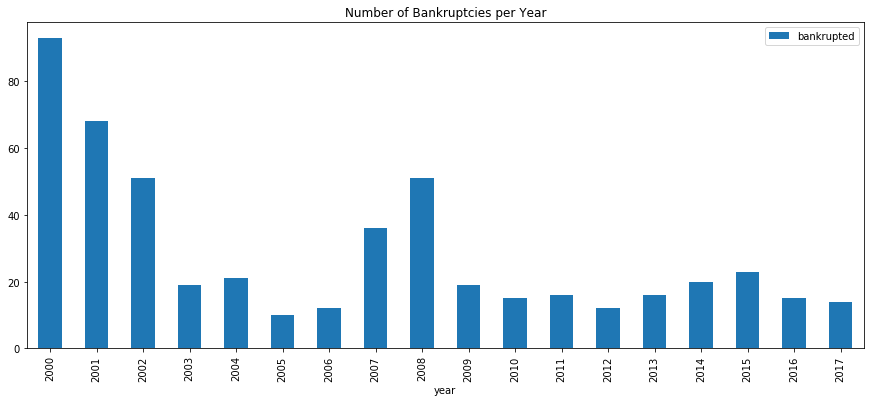

In [37]:
fund_ratio_bank.groupby('year')[['bankrupted']].sum().plot(kind = 'bar', title = 'Number of Bankruptcies per Year', figsize = (15,6))

In [38]:
final_bank = fund_ratio_bank [fund_ratio_bank['bankrupted']==1]

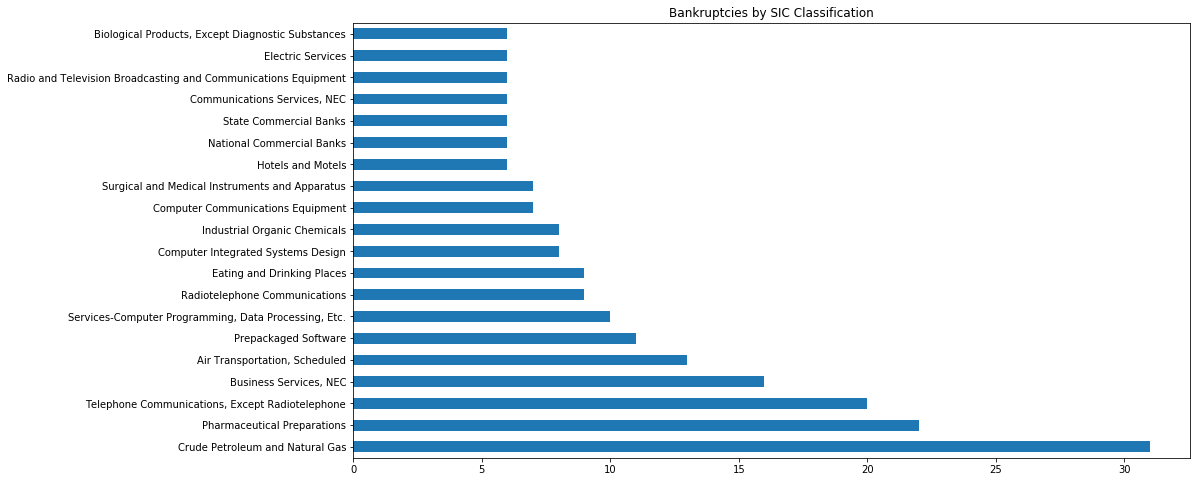

In [39]:
# rotate x labels 45 degrees
# final_bank['SIC_CODE_DESCRIP'].value_counts(ascending = False)[:20].plot(kind = 'bar', title = 'Bankruptcies by SIC Classification', figsize = (15,8))


final_bank['SIC_CODE_DESCRIP'].value_counts(ascending = False)[:20].plot.barh(title = 'Bankruptcies by SIC Classification', figsize = (15,8))

Most bankruptcies occur in small market cap companies


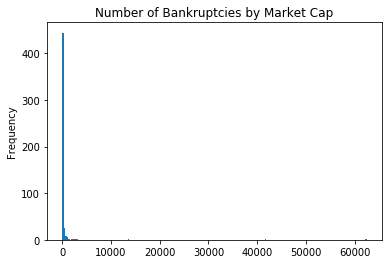

In [40]:
#bankrupt companies usually have small market caps
final_bank['mkvalt'].plot(kind = 'hist', title = 'Number of Bankruptcies by Market Cap', bins = 200)#.value_counts(ascending = False)[:20].plot(kind = 'bar', figsize = (15,8))
print('Most bankruptcies occur in small market cap companies')

## Next steps:
1. figure out why so many bankrupted companies do not have fundamental data (is it how the database was constructed? fundamental dataset would get rid of bankrupted or acquired companies?)

2. figure out why only 500 or so bankruptcies exist in the final dataset, down from 1000 (bankrupt companies with fundamental data) --> hypothesis is some fin ratios companies do not have fundamental data and those happen to be the ones with bankrupt data. Need to check 

3. model development. Note that the current dataset includes data from 2000 - 2019. Need to filter out dates


# Modeling

In [41]:
mask = (fund_ratio_bank['fyear'] >= 2000) & (fund_ratio_bank['fyear'] <= 2010)

df_2000_2010 = fund_ratio_bank[mask]

In [42]:
mask = (fund_ratio_bank['fyear'] == 2011)

df_2011 = fund_ratio_bank[mask]

In [43]:
mask = (fund_ratio_bank['fyear'] == 2012)

df_2012 = fund_ratio_bank[mask]

In [44]:
lista=[]
for i in all_fin_ratios.columns:
    lista.append(i)

In [45]:
lista.append('bankrupted')
lista.append('fyear')

In [46]:
df_2000_2010 = df_2000_2010[lista]
df_2011 = df_2011[lista]
df_2012 = df_2012[lista]


In [47]:
df_2000_2010 = df_2000_2010.drop(columns = ['gvkey'])
df_2011 = df_2011.drop(columns = ['gvkey'])
df_2012 = df_2012.drop(columns = ['gvkey'])

In [48]:
mask = (df_2000_2010['fyear'] >= 2000) & (df_2000_2010['fyear'] <= 2007)
train=df_2000_2010[mask]
test= df_2000_2010[-mask]

In [49]:
y_train= train['bankrupted']
x_train= train.drop(columns=['bankrupted'])
y_test= test['bankrupted']
x_test= test.drop(columns=['bankrupted'])

In [50]:
x_train=x_train.drop(columns=['adate','qdate','fyear','public_date','qmonth'])
x_test=x_test.drop(columns=['adate','qdate','fyear','public_date','qmonth'])

In [51]:
def get_pct(column):
    
    column = float(str(column).rstrip('%')) 
    
    return column

x_train['DIVYIELD'] = x_train['DIVYIELD'].apply(get_pct)
x_test['DIVYIELD'] = x_test['DIVYIELD'].apply(get_pct)

# SGD Classifier
imputation: https://towardsdatascience.com/6-different-ways-to-compensate-for-missing-values-data-imputation-with-examples-6022d9ca0779

In [52]:
from sklearn.linear_model import SGDClassifier

# clf = SGDClassifier(loss="log", max_iter=5).fit(x_train, y_train)
# clf.predict_proba(x_test)

In [53]:
list(x_train.columns)

['CAPEI',
 'bm',
 'evm',
 'pe_op_basic',
 'pe_op_dil',
 'pe_exi',
 'pe_inc',
 'ps',
 'pcf',
 'dpr',
 'npm',
 'opmbd',
 'opmad',
 'gpm',
 'ptpm',
 'cfm',
 'roa',
 'roe',
 'roce',
 'efftax',
 'aftret_eq',
 'aftret_invcapx',
 'aftret_equity',
 'pretret_noa',
 'pretret_earnat',
 'GProf',
 'equity_invcap',
 'debt_invcap',
 'totdebt_invcap',
 'capital_ratio',
 'int_debt',
 'int_totdebt',
 'cash_lt',
 'invt_act',
 'rect_act',
 'debt_at',
 'debt_ebitda',
 'short_debt',
 'curr_debt',
 'lt_debt',
 'profit_lct',
 'ocf_lct',
 'cash_debt',
 'fcf_ocf',
 'lt_ppent',
 'dltt_be',
 'debt_assets',
 'debt_capital',
 'de_ratio',
 'intcov',
 'intcov_ratio',
 'cash_ratio',
 'quick_ratio',
 'curr_ratio',
 'cash_conversion',
 'inv_turn',
 'at_turn',
 'rect_turn',
 'pay_turn',
 'sale_invcap',
 'sale_equity',
 'sale_nwc',
 'rd_sale',
 'adv_sale',
 'staff_sale',
 'accrual',
 'ptb',
 'PEG_trailing',
 'DIVYIELD',
 'PEG_1yrforward',
 'PEG_ltgforward']

In [54]:
x_train

,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,pcf,dpr,...,sale_nwc,rd_sale,adv_sale,staff_sale,accrual,ptb,PEG_trailing,DIVYIELD,PEG_1yrforward,PEG_ltgforward
1,28.326,0.497,12.016,12.852,13.385,15.181,15.181,0.771,20.975,0.118,...,2.286,0.048,0.000,0.0,-0.016,0.792,0.596,0.796,0.642,0.678
2,34.133,0.846,13.648,36.383,36.383,-19.655,-18.387,0.689,5.628,NaN,...,3.053,0.089,0.000,0.0,0.078,0.677,NaN,1.050,-0.332,-0.874
3,-293.430,1.698,8.056,19.031,19.031,-9.920,-9.325,0.598,4.541,NaN,...,4.203,0.055,0.000,0.0,0.109,0.708,NaN,0.965,-0.424,-0.601
4,-253.970,1.106,12.002,29.365,29.767,57.184,80.481,0.678,5.603,0.479,...,3.876,0.049,0.000,0.0,0.059,0.761,NaN,0.828,-8.196,3.590
5,-5.239,1.026,10.382,28.606,28.606,-1.560,-1.560,0.289,2.077,NaN,...,NaN,0.061,0.000,0.0,0.231,0.421,NaN,1.910,-0.065,-0.114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72267,NaN,0.590,21.864,13.700,14.172,14.172,14.172,3.980,11.119,0.000,...,0.300,0.000,0.000,0.0,0.016,1.018,NaN,NaN,0.411,0.489
72268,NaN,0.590,21.864,13.700,14.172,14.172,14.172,3.980,11.119,0.000,...,0.300,0.000,0.000,0.0,0.016,1.018,NaN,NaN,0.411,0.489
72288,NaN,0.703,-14.979,-18.556,-18.556,-16.700,-16.700,60.120,-4.514,NaN,...,0.050,0.000,0.000,0.0,0.068,2.398,NaN,NaN,NaN,NaN
72321,-27.679,0.175,-8.041,-15.238,-15.238,-19.394,-19.394,56.916,-18.434,NaN,...,0.143,0.818,0.001,0.0,-0.016,11.848,NaN,NaN,NaN,NaN


In [55]:
#only keep na < 10% columns ####################################################
temp = pd.DataFrame(1 - x_train.isna().sum() / 37103).reset_index()
use_list = temp[temp[0]>0.9]['index'].to_list()

In [56]:
x_train = x_train[use_list]
x_test = x_test[use_list]


In [57]:
# start the MICE training
# imputed_training=mice(x_train.values)

In [58]:
x_columns = x_train.columns.tolist()

In [59]:
#knn imputation takes forever 
# import sys
# from impyute.imputation.cs import fast_knn
# sys.setrecursionlimit(100000) #Increase the recursion limit of the OS

# # start the KNN training
# imputed_training=fast_knn(x_train.values, k=30)

In [60]:
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer( strategy='mean') #for median imputation replace 'mean' with 'median'
imp_mean.fit(x_train)
imputed_train_df = imp_mean.transform(x_train)

x_train = pd.DataFrame(imputed_train_df).set_axis(x_columns, axis=1, inplace=False)


#impute x_test ####################################################
imp_mean = SimpleImputer( strategy='mean') #for median imputation replace 'mean' with 'median'
imp_mean.fit(x_test)
imputed_test_df = imp_mean.transform(x_test)

x_test = pd.DataFrame(imputed_test_df).set_axis(x_columns, axis=1, inplace=False)

In [61]:
#SGD
clf = SGDClassifier(loss="log").fit(x_train, y_train)
y_pred = clf.predict(x_test)
y_prob = clf.predict_proba(x_test)[:,1]

print ('f1 score:' , f1_score(y_test, y_pred))
print ('roc_auc_score', roc_auc_score(y_test, y_prob))
print('accuracy_score', accuracy_score(y_test, y_pred))

f1 score: 0.013793103448275862
roc_auc_score 0.5030919283968065
accuracy_score 0.9873238188103891


In [62]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print('SGD:', 'TN:', tn, '|FP:' , fp, '|FN:' , fn, '|TP:' ,tp)

SGD: TN: 11137 |FP: 56 |FN: 87 |TP: 1


## XGBOOST

In [63]:
#XGBOOST
xgb = XGBClassifier()
xgb.fit(x_train, y_train)

y_pred = xgb.predict(x_test)
y_prob = xgb.predict_proba(x_test)[:,1]

print ('f1 score:' , f1_score(y_test, y_pred))
print ('roc_auc_score', roc_auc_score(y_test, y_prob))
print('accuracy_score', accuracy_score(y_test, y_pred))

f1 score: 0.2456140350877193
roc_auc_score 0.9706797267772878
accuracy_score 0.9923765623614927


In [64]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print('XGBOOST:', 'TN:', tn, '|FP:' , fp, '|FN:' , fn, '|TP:' ,tp)

XGBOOST: TN: 11181 |FP: 12 |FN: 74 |TP: 14


In [65]:
confusion_matrix(y_test, y_pred)

array([[11181,    12],
       [   74,    14]], dtype=int64)

In [66]:
#test on 2011 data

In [67]:
x_2011 = df_2011.drop(columns=['adate','qdate','fyear','public_date','qmonth'])[use_list]
y_2011 = df_2011['bankrupted']

imp_mean = SimpleImputer( strategy='mean') #for median imputation replace 'mean' with 'median'
imp_mean.fit(x_2011)
imputed_2011_df = imp_mean.transform(x_2011)

x_2011 = pd.DataFrame(imputed_2011_df).set_axis(x_columns, axis=1, inplace=False)

y_pred = xgb.predict(x_2011)
y_prob = xgb.predict_proba(x_2011)[:,1]

print ('f1 score:' , f1_score(y_2011, y_pred))
print ('roc_auc_score', roc_auc_score(y_2011, y_prob))
print('accuracy_score', accuracy_score(y_2011, y_pred))

f1 score: 0.0
roc_auc_score 0.9752008188513829
accuracy_score 0.9962536023054755


In [68]:
y_df = pd.DataFrame(y_2011.array)
pred_df = pd.DataFrame(y_pred)
prob_df = pd.DataFrame(y_prob)

compare_df = pd.concat([y_df, pred_df, prob_df], axis=1).set_axis(['True','Pred', 'Proba'], axis=1, inplace=False)

In [69]:
tn, fp, fn, tp = confusion_matrix(y_2011, y_pred).ravel()
print('XGB on 2011:', 'TN:', tn, '|FP:' , fp, '|FN:' , fn, '|TP:' ,tp)

XGB on 2011: TN: 3457 |FP: 0 |FN: 13 |TP: 0


In [70]:
#test on 2012 data

In [71]:
x_2012 = df_2012.drop(columns=['adate','qdate','fyear','public_date','qmonth'])[use_list]
y_2012 = df_2012['bankrupted']

imp_mean = SimpleImputer( strategy='mean') #for median imputation replace 'mean' with 'median'
imp_mean.fit(x_2012)
imputed_2012_df = imp_mean.transform(x_2012)

x_2012 = pd.DataFrame(imputed_2012_df).set_axis(x_columns, axis=1, inplace=False)

y_pred = xgb.predict(x_2012)
y_prob = xgb.predict_proba(x_2012)[:,1]

print ('f1 score:' , f1_score(y_2012, y_pred))
print ('roc_auc_score', roc_auc_score(y_2012, y_prob))
print('accuracy_score', accuracy_score(y_2012, y_pred))

f1 score: 0.15384615384615385
roc_auc_score 0.9603372215756854
accuracy_score 0.9967359050445104


In [72]:
tn, fp, fn, tp = confusion_matrix(y_2012, y_pred).ravel()
print('XGB on 2011:', 'TN:', tn, '|FP:' , fp, '|FN:' , fn, '|TP:' ,tp)

XGB on 2011: TN: 3358 |FP: 1 |FN: 10 |TP: 1


In [73]:
xgb

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

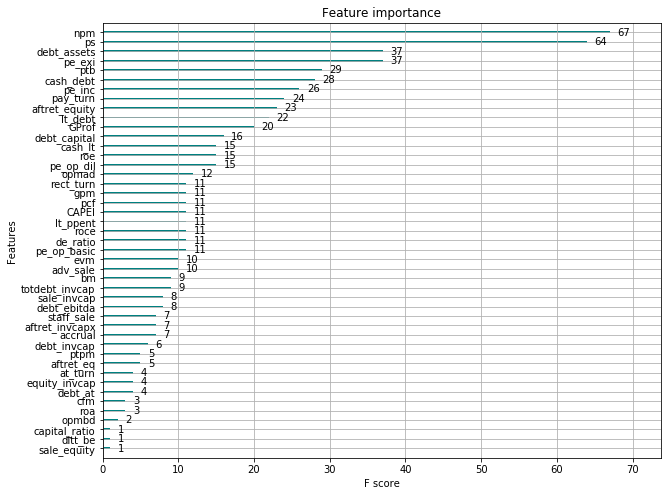

In [74]:
ax =plot_importance(xgb, color = 'teal')
fig = ax.figure
fig.set_size_inches(10,8)

npm: Net Profit Margin	
ps: Price/Sales	
debt_assets: Total Debt/Total Assets	
PE_exi: 	P/E (Diluted, Excl. EI)
ptb: Price/Book	
cash_debt: Cash Flow/Total Debt	
pe_inc: P/E (Diluted, Incl. EI)	
pay_turn: Payables Turnover	
aftret_equity: After-tax Return on Total Stockholders Equity	
lt_debt: Long-term Debt/Total Liabilities	
Gprof: Gross Profit/Total Assets	
debt_capital: Total Debt/Capital	
cash_lt: Cash Balance/Total Liabilities	
